In [1]:
# ==== Chunk 0: Setup ====
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Forecasting libs
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA

# Project paths
DATA = Path("D:/LightPollutionProject/data/processed")
PLOTS = Path("D:/LightPollutionProject/plots")
PLOTS.mkdir(parents=True, exist_ok=True)

print("Setup complete ✅")


D:\Anaconda3\envs\lightpollution\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Setup complete ✅


Loaded dataset:
   year  asia_avg_density
0  2013          1.065663
1  2014          1.154520
2  2015          0.956228
3  2016          0.791901
4  2017          1.894944


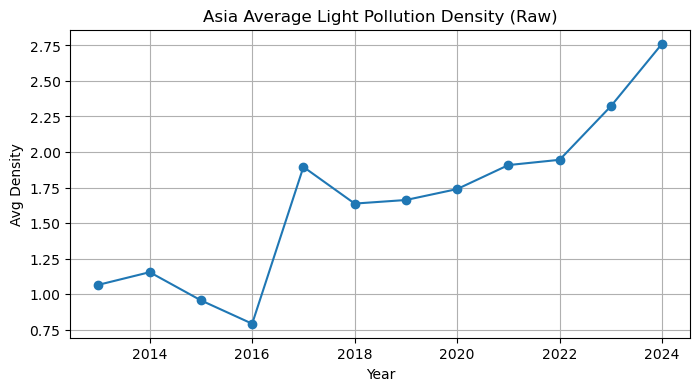

In [2]:
# ==== Chunk 1: Load Data ====
yearly_path = DATA / "asia_year.csv"
df_year = pd.read_csv(yearly_path)

print("Loaded dataset:")
print(df_year.head())

# Plot raw trend
plt.figure(figsize=(8,4))
plt.plot(df_year["year"], df_year["asia_avg_density"], marker="o")
plt.title("Asia Average Light Pollution Density (Raw)")
plt.xlabel("Year")
plt.ylabel("Avg Density")
plt.grid(True)
plt.show()


20:54:07 - cmdstanpy - INFO - Chain [1] start processing
20:54:09 - cmdstanpy - INFO - Chain [1] done processing
D:\Anaconda3\envs\lightpollution\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


✅ Prophet forecast saved


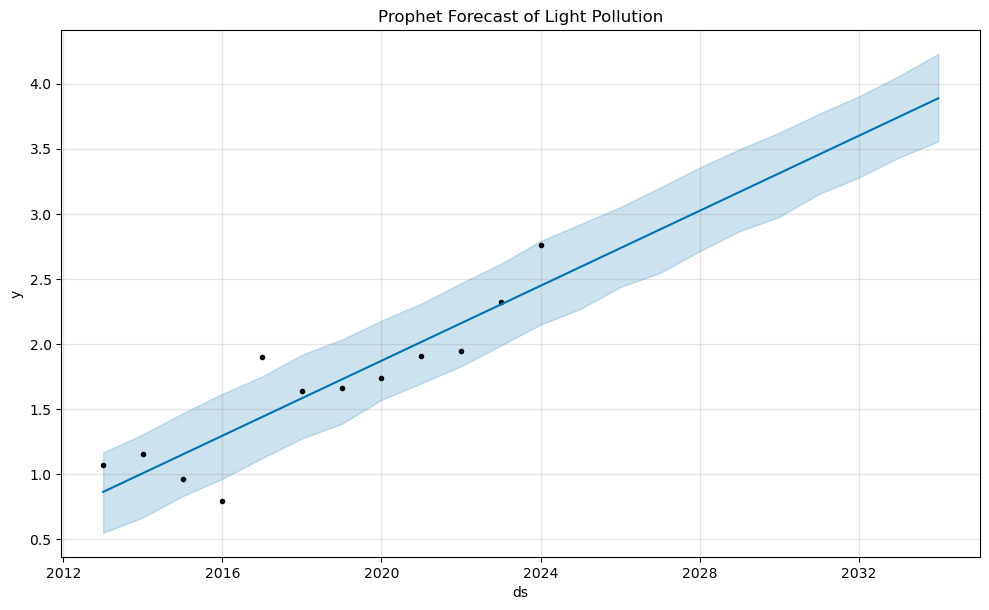

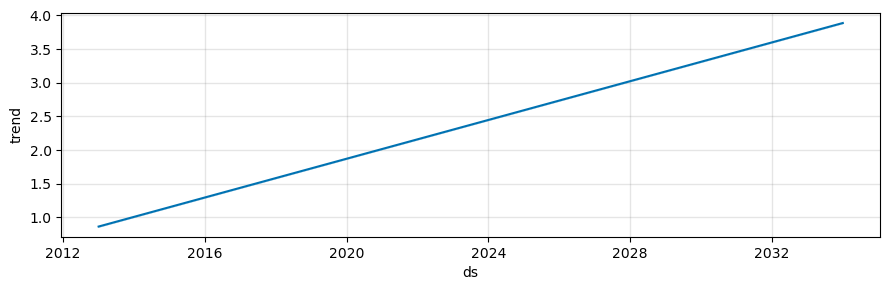

In [3]:
# ==== Chunk 2: Prophet Forecast ====
df_prophet = df_year.rename(columns={"year": "ds", "asia_avg_density": "y"})
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="%Y")

if len(df_prophet) >= 3:
    model = Prophet(yearly_seasonality=False)
    model.fit(df_prophet)

    # Predict next 10 years
    future = model.make_future_dataframe(periods=10, freq="Y")
    forecast = model.predict(future)

    # Save forecast
    forecast.to_csv(DATA / "prophet_forecast.csv", index=False)

    # Plot
    fig1 = model.plot(forecast)
    plt.title("Prophet Forecast of Light Pollution")
    fig1.savefig(PLOTS / "prophet_forecast.png")

    fig2 = model.plot_components(forecast)
    fig2.savefig(PLOTS / "prophet_components.png")

    print("✅ Prophet forecast saved")
else:
    print("❌ Not enough data for Prophet")


D:\Anaconda3\envs\lightpollution\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
D:\Anaconda3\envs\lightpollution\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
D:\Anaconda3\envs\lightpollution\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
D:\Anaconda3\envs\lightpollution\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index i

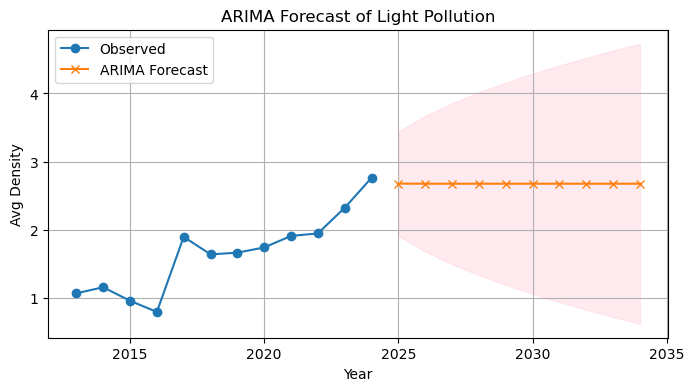

✅ ARIMA forecast saved


In [4]:
# ==== Chunk 3: ARIMA Forecast ====
series = df_year.set_index("year")["asia_avg_density"]

try:
    arima_model = ARIMA(series, order=(1,1,1))
    arima_fit = arima_model.fit()

    # Forecast next 10 years
    forecast_arima = arima_fit.get_forecast(steps=10)
    pred_mean = forecast_arima.predicted_mean
    conf_int = forecast_arima.conf_int()

    # Save results
    results_df = pd.DataFrame({
        "year": range(series.index.max()+1, series.index.max()+11),
        "forecast": pred_mean.values
    })
    results_df.to_csv(DATA / "arima_forecast.csv", index=False)

    # Plot
    plt.figure(figsize=(8,4))
    plt.plot(series, label="Observed", marker="o")
    plt.plot(results_df["year"], results_df["forecast"], label="ARIMA Forecast", marker="x")
    plt.fill_between(results_df["year"], conf_int.iloc[:,0], conf_int.iloc[:,1], color="pink", alpha=0.3)
    plt.legend()
    plt.title("ARIMA Forecast of Light Pollution")
    plt.xlabel("Year")
    plt.ylabel("Avg Density")
    plt.grid(True)
    plt.savefig(PLOTS / "arima_forecast.png")
    plt.show()

    print("✅ ARIMA forecast saved")
except Exception as e:
    print("❌ ARIMA failed:", e)


In [5]:
# ==== Chunk 4: Summary Save ====
summary_path = DATA / "prediction_summary.txt"

with open(summary_path, "w") as f:
    f.write("Light Pollution Forecast Summary (Asia)\n")
    f.write("="*40 + "\n\n")

    if (DATA / "prophet_forecast.csv").exists():
        f.write("✔ Prophet forecast generated (see prophet_forecast.csv)\n")
    if (DATA / "arima_forecast.csv").exists():
        f.write("✔ ARIMA forecast generated (see arima_forecast.csv)\n")

    f.write("\nCheck plots folder for forecast graphs.\n")

print(f"Summary written to {summary_path}")


UnicodeEncodeError: 'charmap' codec can't encode character '\u2714' in position 0: character maps to <undefined>